# Inverse kinematics
This note considers the problem of inverse kinematics, ie solving at each control cycle of the robot a quadratic program from the derivatives (jacobian) of the current state. It introduces the basic function to compute the Jacobians of the robot, and how to use them to compute an inverse-kinematics control law. One of the key difficulties is to understand in which frames each quantities is computed (might be in the world frame, in the local frame attached to the end effector, in some arbitrary goal frame, etc), as we should never mixed quantities expressed in different frames without transporting them in the right frame. 


In [1]:
import magic_donotload

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.


## Set up
We will use a Gepetto-viewer, and the linear algebra of NumPy.

In [2]:
import math
import time
import pinocchio as pio
from pinocchio.utils import *
import numpy as np
from numpy.linalg import inv,pinv,norm,eig
pio.switchToNumpyMatrix()
import matplotlib.pylab as plt
plt.ion()

We will use the Tiago robot. This mobile manipulator from PAL Robotics as a mobile basis which can move in the plane (3 dof), a manipulator arm (7 dof) and a head (2 dof) both mounted on a prismatic axis moving vertically (1 dof). This makes 3 dof for the basis, and 9 dof for the body. It also has 2 extra joints tot figure the wheels, which are not very useful for this notebook. The wheels and the basis rotations are represented by the cos and sin of the angle. The size of the configuration vector is then 18, while the velocity vector has dimension 15.

A load function is available to make it easy to load the robot.

In [3]:
from tp3.tiago_loader import loadTiago
pio.switchToNumpyMatrix()
robot = loadTiago(initViewer=True)
gv = robot.viewer.gui
robot.model

Nb joints = 14 (nq=18,nv=15)
  Joint 0 universe: parent=0
  Joint 1 root_joint: parent=0
  Joint 2 torso_lift_joint: parent=1
  Joint 3 arm_1_joint: parent=2
  Joint 4 arm_2_joint: parent=3
  Joint 5 arm_3_joint: parent=4
  Joint 6 arm_4_joint: parent=5
  Joint 7 arm_5_joint: parent=6
  Joint 8 arm_6_joint: parent=7
  Joint 9 arm_7_joint: parent=8
  Joint 10 head_1_joint: parent=2
  Joint 11 head_2_joint: parent=10
  Joint 12 wheel_left_joint: parent=1
  Joint 13 wheel_right_joint: parent=1

The configuration is represented by a vector of larger dimension, subject to constraints (cos^2+sin^2=1). It is not possible to randomly sample a configuration vector q, as these constraints should be respected. Similarly, we should take care when integrating a velocity as summing a configuration q with a velocity v will not work (dimensions do not match). Two functions in Pinocchio implements these functionnalities.

In [4]:
q = pio.randomConfiguration(robot.model)
vq = rand(robot.model.nv)*2-1
DT = 1e-2
qnext = pio.integrate(robot.model,q,vq*DT)

A simple example moving the robot in Gepetto-Viewer following a constant (random) velocity is as follows.

In [5]:
for t in range(1000):
    q = pio.integrate(robot.model,q,vq*DT)
    robot.display(q)
    time.sleep(DT/10)

The robot is mobile, hence the camera view in Gepetto Viewer is not always centered. Hit <space> in Gepetto-Viewer to center the camera.

## Forward kinematics and Jacobian
We recall first the basic method to compute the robot forward kinematics.
We will consider two frames of interest on the robot: the first one, named <tool> is at the tip of the end-effector ; the second one, named <basis>, is on the front of the robot basis, 10 cm above the ground. Both are represented in Gepetto-Viewer by a frame composed of three RGB arrows. 

In [6]:
IDX_TOOL = robot.model.getFrameId('frametool')
IDX_BASIS = robot.model.getFrameId('framebasis')
robot.model.frames[IDX_TOOL]

Frame name: frametool paired to (parent joint/ previous frame)(9/51)
with relative placement wrt parent joint:
  R =
0 1 0
0 0 1
1 0 0
  p =    0    0 0.06


### Computing frame placement
These frames are computed by the Pinocchio function framesForwardKinematics, whose results are stored in robot.data.oMf.     

In [7]:
pio.framesForwardKinematics(robot.model,robot.data,q)
print("Tool placement:",robot.data.oMf[IDX_TOOL])
print("Basis placement:",robot.data.oMf[IDX_BASIS])

Tool placement:   R =
 -0.74417 -0.666567 0.0435859
 0.302252 -0.394192 -0.867904
 0.595697 -0.632694  0.494816
  p = -0.0581327     1.7657     4.8695

Basis placement:   R =
-0.708747  0.705463         0
-0.705463 -0.708747         0
        0         0         1
  p = -0.245204   1.61875       0.1



The tool-placement matrix oMtool represents the displacement from the world frame F_o to the tool frame F_tool. It is composed on a rotation matrix oRtool and a 3D vector o_OT: oMf = [ oRf o_OT ], when o_OT is the vector from the origin of frame F_o to the origin of from F_tool ; this vector is expressed in the world frame F_o. We can rather express OT in the tool frame F_tool by multiplying it by oRtool

In [8]:
oMtool = robot.data.oMf[IDX_TOOL]
oRtool = oMtool.rotation; o_OT = oMtool.translation
tool_OT = oRtool.T * o_OT

### Computing Jacobians
The jacobian of a frame of the robot is computed using pio.computeFrameJacobian.

In [9]:
Jtool = pio.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL)
Jtool.shape

(6, 15)

This matrix has 6 rows and NV=15 columns. It corresponds to the "spatial" 6D velocity of the end effector. Let's first focus on the 3 first rows, corresponding to the linear velocity.

In [10]:
Jtool3 = Jtool[:3,:]

#### Jacobian as a velocity operator
A first way to understand what is this matrix is to see that as an operator that converts the velocity in the configuration space into the linear velocity of the end effector.

In [11]:
vtool = Jtool3*vq

But in which frame is vtool expressed? The choice in Pinocchio (following algorithmic principles described in [Featherstone 2009]) is to expressed quantities in the local frame by default. So vtool is expressed in the tool frame F_tool (or more precisely, the Galilean frame coinciding with F_tool at the current time instant). We should better denote it with its frame.

In [12]:
tool_Jtool = pio.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL)
tool_Jtool3 = tool_Jtool[:3,:]
tool_vtool = tool_Jtool3*vq

Well, in the code, these explicit notations are maybe to much. It is your choice to use them or not. For sure, you should use similar notations on the paper board when formulating your algorithm, but maybe you prefer lighter variable naming for implementing it.
The tool velocity is easier to interpret in the world frame.

In [13]:
o_vtool = oRtool*tool_vtool

We generalize this notation to the jacobian expressed in the world frame F_o:

In [14]:
o_Jtool3 = oRtool*tool_Jtool3

#### Jacobian as a derivative
A second interpretation to explain what is the jacobian is to observe that it is the derivative of the vector o_OT (the tool position in world frame). Indeed o_OT is a function of q: o_OT(q). We can take its derivative with respect to q, denoted d o_OT / dq. This derivatives is equal to the Jacobian expressed in the world frame F_o: d o_OT / dq = o_Jtool.
To be convinced of that, let's check the finite differences. We take a small movement dq, and see that the change in position o_OT(q+dq) corresponds to the linear prediction o_Jtool3*dq.

In [15]:
EPS = 1e-3
dq = rand(robot.model.nv)*2-1;dq *= EPS                  # Sample between -0.001 and 0.001
q2 = pio.integrate(robot.model,q,dq)                     # q2=q+dq
pio.framesForwardKinematics(robot.model,robot.data,q)
o_OT = robot.data.oMf[IDX_TOOL].translation.copy()       # tool position for q
pio.framesForwardKinematics(robot.model,robot.data,q2)
o_OT2 = robot.data.oMf[IDX_TOOL].translation.copy()      # tool position for q+dq

print((o_OT2 - o_OT).T/EPS)
print((o_Jtool3*dq/EPS).T)

[[ 0.0569808  -0.1214953   0.13007154]]
[[ 0.05701908 -0.12146108  0.13007098]]


#### Jacobian in 6D
The jacobian of the frame indeed as 6 rows, and corresponds to the spatial velocity of the frame. It is expressed locally, in the tool frame (or more precisely the Galilean frame coincinding with the tool frame to the current time instant).

In [16]:
tool_J = pio.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL)
tool_nu = tool_J*vq

We denote by nu the spatial velocity. It is composed by the linear velocity of the center of the frame vtool and the angular velocity of the tool frame, both expressed in the tool frame: tool_nu = [ tool_vtool, tool_w ].



In [17]:
tool_vtool = tool_nu[:3] ; tool_w = tool_nu[3:]

We can rather expressed the spatial velocity in the world frame F_o by multiplying it by the so-called action matrix oXtool.

In [18]:
o_nu = oMtool.action*tool_nu

#### Log in SE(3)
Finally, the log operator transforms a displacement M in SE(3) into the spatial (6D) velocity that should be applied during 1 second to achieve this displacement. The spatial velocity is expressed in the frame at the origin of the displacement (i.e. nu=log(oMtool) is expressed in the world frame F_o). In Pinocchio, the log returns an object of class Motion, that can be converted to a numpy vector.

In [19]:
o_nu = pio.log(oMtool).vector
print(o_nu.T)

[[ 5.27778143  1.0798165   3.18359341  0.52337589 -1.22795498  2.15579202]]


## Inverse kinematics for the moving the robot effector
We will first move only the robot end effector, to reach a target defined by a frame F_goal.

In [20]:
# %load -r 25-29 tp3/inverse_kinematics.py
oMgoal = pio.SE3(pio.Quaternion(-0.4, 0.02, -0.5, 0.7).normalized().matrix(),
                 np.matrix([.2, -.4, .7]).T)
gv.addXYZaxis('world/framegoal', [1., 0., 0., 1.], .015, .2)
gv.applyConfiguration('world/framegoal', list(pio.se3ToXYZQUAT(oMgoal).flat))


True

### Position the effector (3d)
It is time to write your first control law. Write a for-loop to iterate along the control cycles of the robot. At each control cycle, you should:
* compute the Jacobian 3D in the world frame o_Jtool3
* compute the vector from the tool to the goal, expressed in world frame: o_TG = o_goal - o_tool
* compute the control law as vq=-pinv(J)*o_TG
* integrated the velocity vq during DT to get a new configuration q.
You might want to start from the following initial configuration, or from any random one.

In [21]:
# %load -r 31-32 tp3/inverse_kinematics.py
q0 = np.matrix([[ 0.  ,  0.  ,  0.  ,  1.  ,  0.18,  1.37, -0.24, -0.98,  0.98,
                  0.  ,  0.  ,  0.  ,  0.  , -0.13,  0.  ,  0.  ,  0.  ,  0.  ]]).T

It is a good idea to store the values of the error between tool and goal o_TG, to plot them later. For that, simply append each o_TG computed at every control cycle in a list.

In [26]:
# %load -r 34-51 tp3/inverse_kinematics.py
q = q0.copy()
herr = [] # Log the value of the error between tool and goal.
# Loop on an inverse kinematics for 200 iterations.
for i in range(200):  # Integrate over 2 second of robot life
    pio.framesForwardKinematics(robot.model, robot.data, q)  # Compute frame placements
    oMtool = robot.data.oMf[IDX_TOOL]           # Placement from world frame o to frame f oMtool
    oRtool = oMtool.rotation                    # Rotation from world axes to tool axes oRtool 
    tool_Jtool = pio.computeFrameJacobian(robot.model, robot.data, q, IDX_TOOL)  # 6D jacobian in local frame
    o_Jtool3 = oRtool*tool_Jtool[:3,:]          # 3D jacobian in world frame
    o_TG = oMtool.translation-oMgoal.translation  # vector from tool to goal, in world frame
    
    vq = -pinv(o_Jtool3)*o_TG

    q = pio.integrate(robot.model,q, vq * DT)
    robot.display(q)
    time.sleep(1e-3)

    herr.append(o_TG) 

It is interesting to plot the behavior of the robot. If the error at each iteration has been stored as a list of 3x1 matrices, the following code plots it.

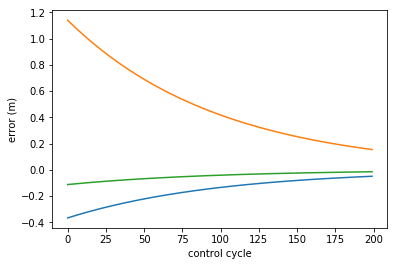

In [27]:
plt.plot(np.hstack(herr).T)
plt.xlabel('control cycle'); plt.ylabel('error (m)');

We can observe that each component of the error converges toward 0 following an exponential trajetory. The convergence is assymptotic. To fasten the convergence, increase the gain of the control law (vq = - lambda*pinv(J)*e), where the gain lambda has yet been set to 1.

### Place the end effector (6D)
The previous control law brings the center of the effector toward the center of the goal frame. However, it does not control the orientation of the end effector: the axes of the two frames F_tool and F_goal do not converge.
We should now modify the control law to take into account the tool orientation. For that, we compute the error to be the SE(3) log of the displacement from the tool frame F_tool to the goal frame F_goal.

In [28]:
toolMgoal = oMtool.inverse()*oMgoal
tool_nu = pio.log(toolMgoal).vector

This error tool_nu is a 6d vector, that can be interpreted as the spatial (6d) velocity that should be applied during 1 second to displace the tool frame F_tool (placed at oMtool) to the goal frame F_goal (placed at oMgoal). This spatial velocity is expressed in the tool frame F_tool. It then corresponds to the 6D jacobian, that is also computed in the same frame F_tool.

Implement a second control law, following the same pattern than the previous control law. At each control cycle, you should:
* compute the displacement between F_tool and F_goal, denoted toolMgoal
* compute the 6D error using the SE(3) log tool_nu
* compute the 6D jacobian tool_Jtool
* compute the control law vq = pinv(J)*nu
* integrate the robot velocity vq during DT to get a new configuration q
* log the error by storing it in a list herr.

In [ ]:
# %load -r 53-66 tp3/inverse_kinematics.py
q = q0.copy()
herr = []
for i in range(1000):  # Integrate over 2 second of robot life
    pio.framesForwardKinematics(robot.model, robot.data, q)  # Compute frame placements
    oMtool = robot.data.oMf[IDX_TOOL]                 # Placement from world frame o to frame f oMtool  
    tool_nu = pio.log(oMtool.inverse()*oMgoal).vector  # 6D error between the two frame
    tool_Jtool = pio.computeFrameJacobian(robot.model, robot.data, q, IDX_TOOL)  # Get corresponding jacobian
    vq = pinv(tool_Jtool)*tool_nu

    q = pio.integrate(robot.model,q, vq * DT)
    robot.display(q)
    time.sleep(1e-3)

    herr.append(tool_nu)

The tool frame F_tool converges toward the gooal frame F_goal: the center and the axes are finally aligned. The trajectory of the tool center is not a straight line, as the frame F_tool follows a "straight" line, not in R^3 but in SE(3).
We can also plot the error (assuming that herr is a list of the 6D errors herr).

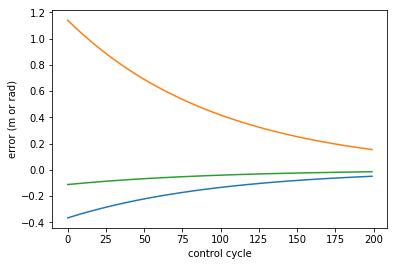

In [32]:
plt.plot(np.hstack(herr).T);
plt.xlabel('control cycle'); plt.ylabel('error (m or rad)');

### Inverse kinematics for two tasks
We yet controlled the robot with a single task (either the 3d position or the 6d placement errors). Let's see how to take into account a second task. Let's first introduce a second task. 

#### Introducing a second task: control the gaze
The robot has an additional frame named F_gaze, attached to the head and located 40 cm in front of the cameras. The task will be to position (3d) the center of this frame on an object of interest (a red ball).

In [33]:
# %load -r 24-31 tp3/control_head.py
IDX_GAZE = robot.model.getFrameId('framegaze')

gv.addXYZaxis('world/framegaze', [1., 0., 0., 1.], .03, .1)
gv.addSphere('world/ball',.1,[ 1.,0.,0.,1.])
ball = np.matrix([ 0.1,0.2,1.0 ]).T
gv.applyConfiguration('world/ball', list(ball.flat)+[1,0,0,0])
robot.display(robot.q0)


Controlling this point can be done by achieving a simple variation of the control law for positioning (3d) the robot tool.

In [34]:
# %load -r 41-58 tp3/control_head.py
q = q0.copy()
herr = [] # Log the value of the error between gaze and ball.
# Loop on an inverse kinematics for 200 iterations.
for i in range(200):  # Integrate over 2 second of robot life
    pio.framesForwardKinematics(robot.model, robot.data, q)  # Compute frame placements
    oMgaze = robot.data.oMf[IDX_GAZE]           # Placement from world frame o to frame f oMgaze
    oRgaze = oMgaze.rotation                    # Rotation from world axes to gaze axes oRgaze 
    gaze_Jgaze = pio.computeFrameJacobian(robot.model, robot.data, q, IDX_GAZE)  # 6D jacobian in local frame
    o_Jgaze3 = oRgaze*gaze_Jgaze[:3,:]          # 3D jacobian in world frame
    o_GazeBall = oMgaze.translation-ball        # vector from gaze to ball, in world frame
    
    vq = -pinv(o_Jgaze3)*o_GazeBall

    q = pio.integrate(robot.model,q, vq * DT)
    robot.display(q)
    time.sleep(1e-3)

    herr.append(o_GazeBall) 

#### Performing 2 tasks

We now have two tasks (e1,J1) controlling the tool and (e2,J2) controlling the gaze. 

The null space projector of +J1+ can be computed using the pseudoinverse.
Following the control law performing task 1 and task 2 in the null space of task 1 is:
$$vq_1 = J_1^+ v_1^*$$
$$P_1 = I_9 - J_1^+ J_1$$
$$vq_2 = vq_1 + (J_2 P_1)^+ ( v_2^* - J_2 vq_1)$$

You can now implement a control law solving the two tasks, i.e positioning the tool while controlling the gaze.

In [35]:
%do_not_load -r 60-89 tp3/control_head.py

A third task can be implemented as well by computing the null space of the two first tasks

In [36]:
Pgaze = Ptool - pinv(o_Jgaze3*Ptool)*o_Jgaze3*Ptool

## Homework

Load an extra cube in the viewer to figure a table. First control the robot hand to reach an arbitrary point on the table (don't mind for the collision). Then implement a control law to control three tasks:
* the tool frame should be kept on the table (i.e. only the z component of the error matter, select only the 3rd row of the matrix).
* the gaze should be control to reach the position of a ball object positionned on the table.
* the center of the basis frame should reach a given target on the floor. For this task, only the x- and y- component of the task matter, select only the 2 first rows.
